# Project : Clustering OpenFoodFact
---

L'objectif de ce projet est ....

Le clustering est une méthode d'analyse de données non supervisée qui consiste à regrouper des données similaires dans des ensembles appelés clusters. L'objectif est de trouver des structures dans les données qui permettent de les regrouper en groupes homogènes, tout en les différenciant des autres groupes.

Le processus de clustering peut être divisé en plusieurs étapes, à savoir :

Partie 1 : L'exploration et le nettoyage des données 

Partie 2 : La sélection des données pertinentes : cette étape consiste à sélectionner les données qui seront utilisées pour le clustering. Les données peuvent inclure des variables telles que des mesures de performances, des caractéristiques, des comportements ou des préférences.

Partie 3 : Le choix des variables à utiliser : il est important de sélectionner les variables qui permettent de différencier les données de manière significative.

Partie 4 : La définition d'une mesure de similarité : il est nécessaire de définir une mesure de similarité pour déterminer la proximité entre les données.

Partie 5 : Le choix de l'algorithme de clustering : il existe plusieurs algorithmes de clustering disponibles, chacun ayant des avantages et des inconvénients. Le choix de l'algorithme dépend de la nature des données, de la taille de l'ensemble de données et du nombre de clusters souhaités.Dans notre cas nous allons tester tout les algorithme et les comparer

Partie 6 : L'évaluation des clusters : il est important d'évaluer la qualité des clusters pour s'assurer qu'ils sont pertinents et qu'ils répondent aux objectifs de l'analyse. Les mesures d'évaluation courantes incluent l'indice de silhouette, la variance intra-cluster et la variance inter-cluster.



### Import Libraries and fonction from py file
---

In [1]:
"""Data loading tools
"""
import yaml
import itertools
import pandas as pd
import os
import numpy as np
from scripts.preprocessing import *
from scripts.manage_outliers import *
from scripts.encoding_categorial_data import *
from scripts.data_loader import *
from scripts.scaling_data import *

# Text process
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import UnigramTagger,pos_tag
from nltk import bigrams, ngrams
import re
import nltk

nltk.download('punkt')
nltk.download('wordnet')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

[nltk_data] Downloading package punkt to /home/grace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/grace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load dataset
---

In [2]:
print(os.getcwd())
data = get_data(file_path = "./data/en.openfoodfacts.org.products.csv", nrows=1000)
data.head()

/home/grace/Documents/Machine-Learning/OpenFoodFact/Projet_ML_Clustering_OpenFoodFact
Reading dataset ...


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,product_name,abbreviated_product_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,nutrinet-sante,jeunes pousses,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,207025004,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1656948610,2022-07-04T15:30:10Z,1656948613,2022-07-04T15:30:13Z,kiliweb,Andrè,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1656488106,2022-06-29T07:35:06Z,stephane,L.casei,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26772226,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1654250311,2022-06-03T09:58:31Z,1654270474,2022-06-03T15:34:34Z,quentinbrd,Skyr,NaN,...,NaN,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,kiliweb,Vitória crackers,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataframe cleaning and exploration
---

#### Visualisation du taux de remplissage des colonnes 

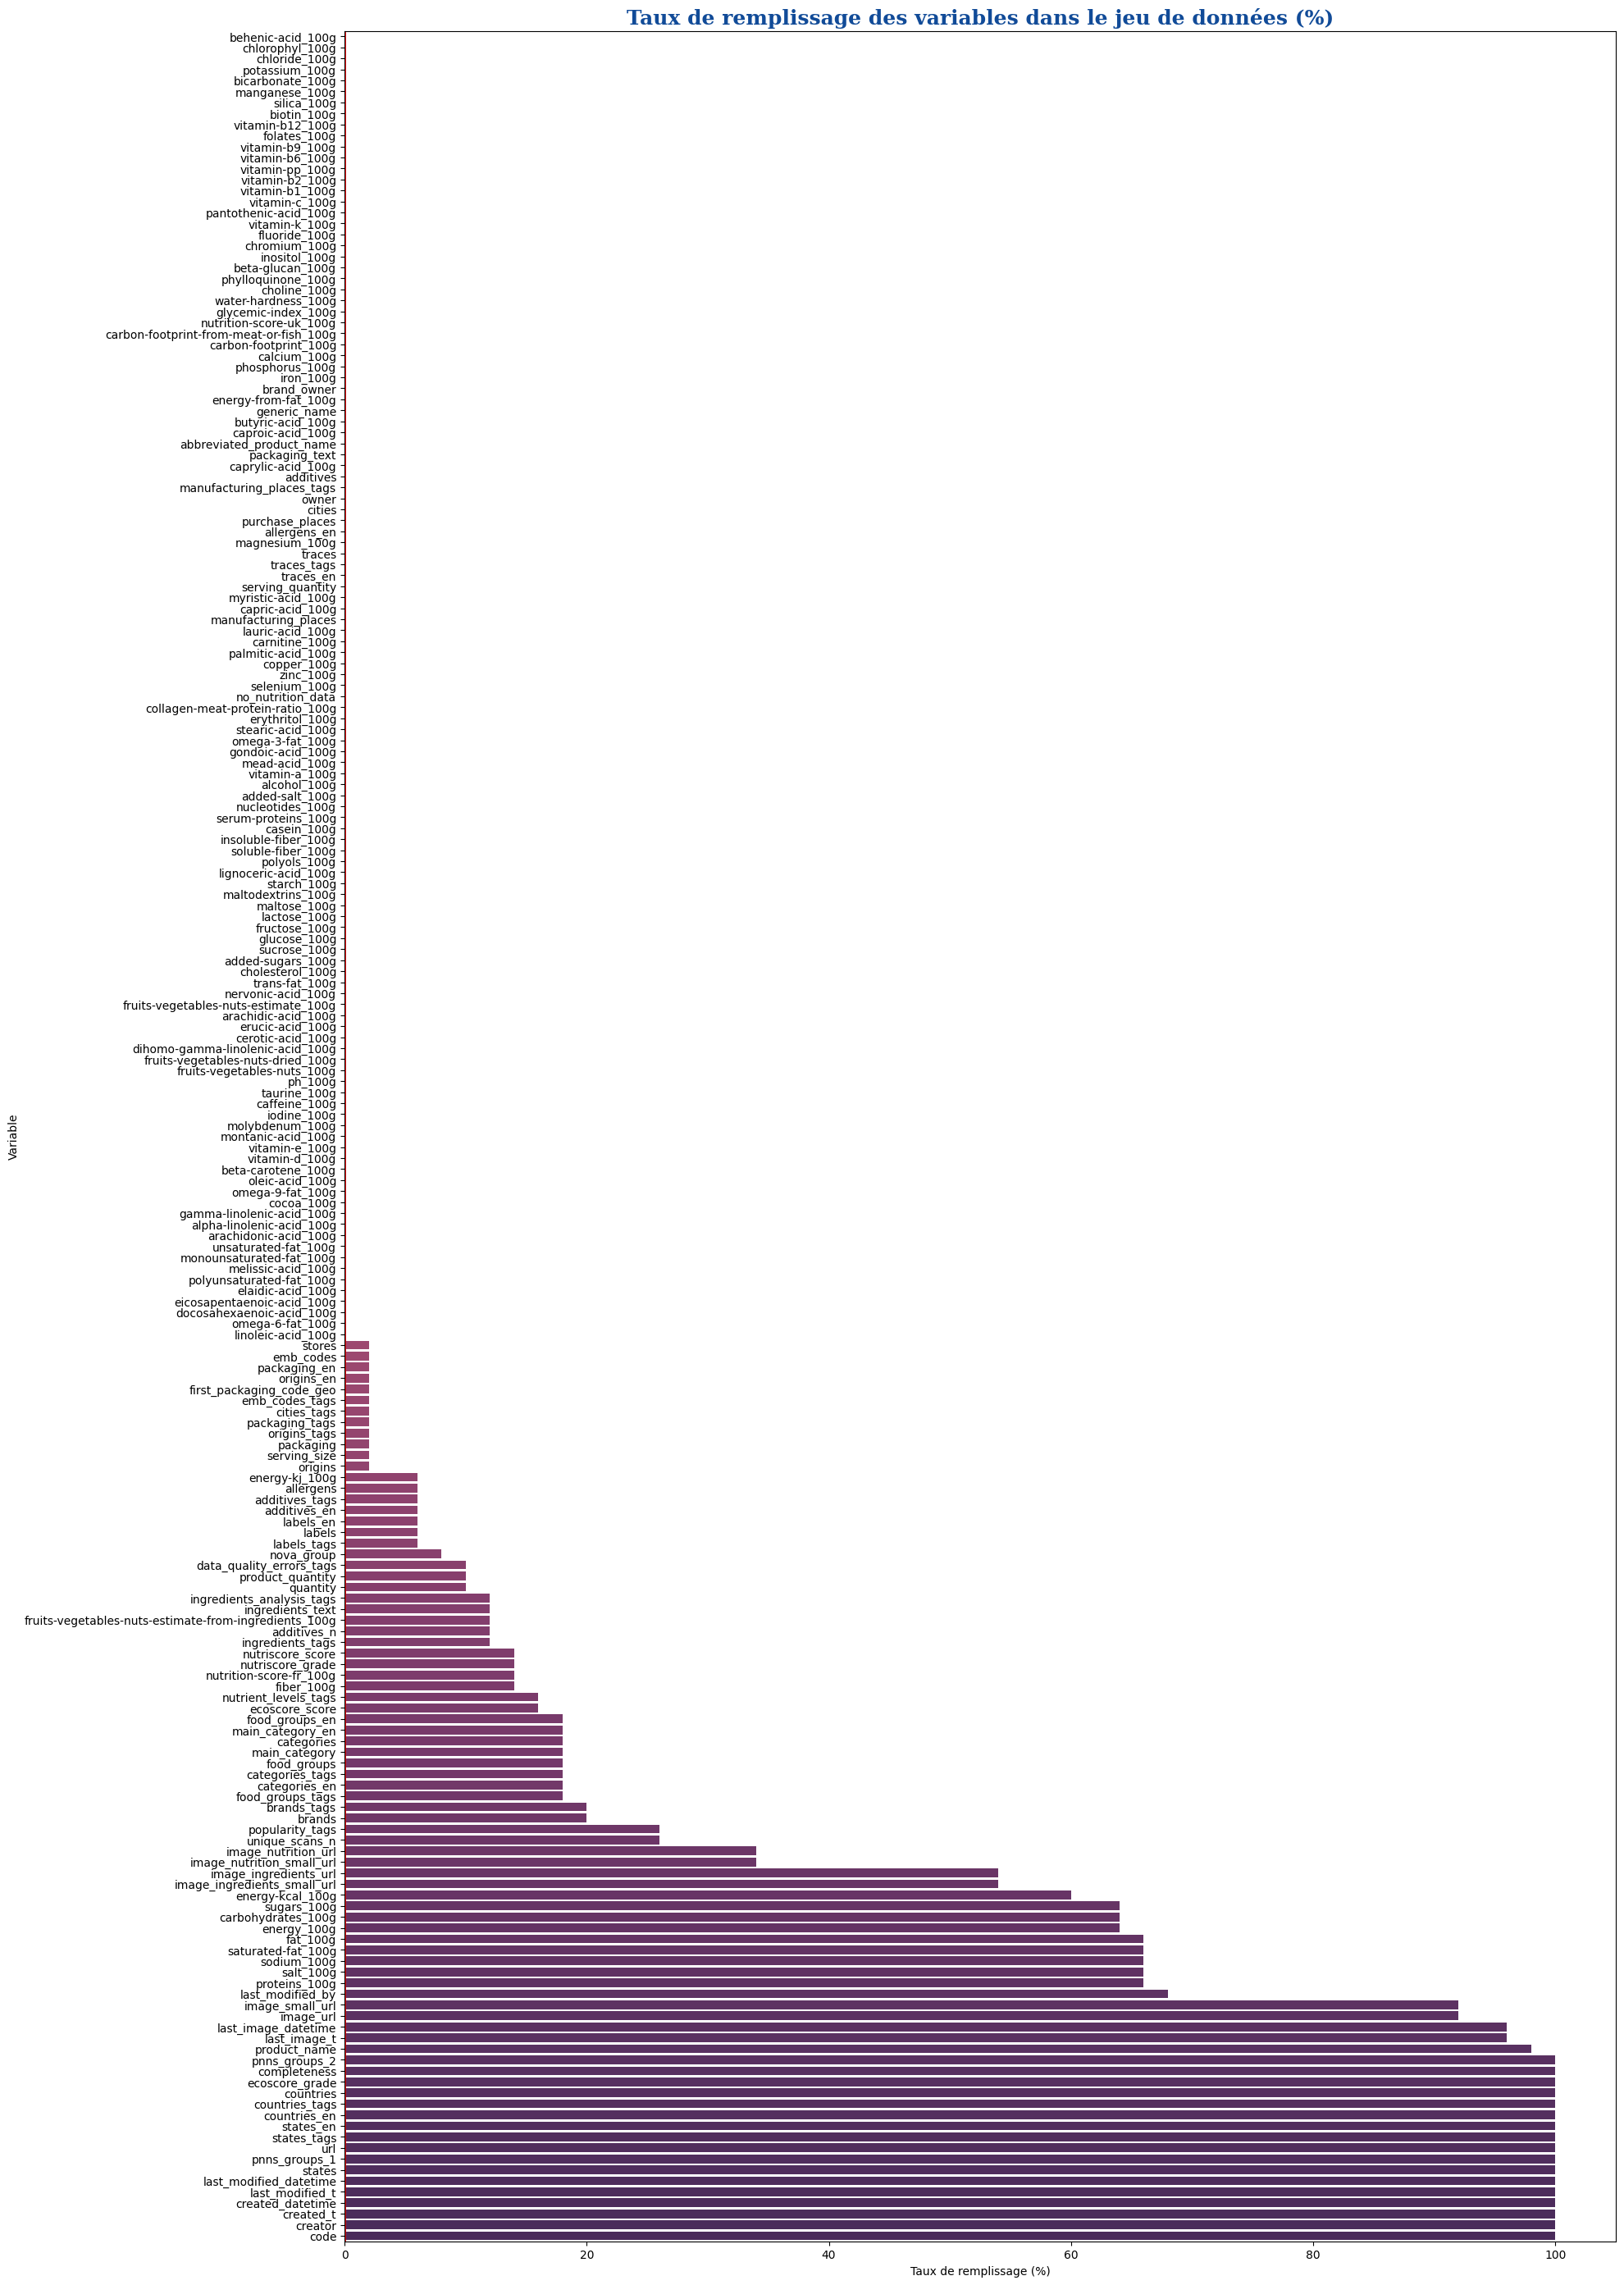

In [3]:
fill_rate_features(data)

##### Remarque : 
- - -
il y a certaines colonnes qui ne contiennent aucune valeure.
Selon notre analyse, les colonnes qui nous paraissent pertinantes sont les colonnes Nutrition Col soit celles contenant le suffixe _100g, ingredients, categories ainsi que l'id de des colonnes

Concernant les colones nutrition, dans notre fonction clean_dataframe se trouvant dans le fichier .py Cleaningdf, nous avons selection les colonnes contenant le suffixe _100g puis nous l'allons ajouter à la liste des colonnes que nous avons jugés bon de garder pour notre analyse.

Dans l'étape suivante, nous allons faire un premier nettoyages sur les colonnes ingredients, categories avant d'appliqué notre fonction de nettoyage clean_dataframe.

#### Colones Ingrédients
- - -

In [4]:
ingredients_col = ['ingredients_text']

print('Pourcentage de valeurs Null par colonnes :\n')

for col in ingredients_col:
    res = (data[col].isnull().sum() / len(data)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')

Pourcentage de valeurs Null par colonnes :

   - ingredients_text : 88.0%


#### Colones Categories
- - -

In [5]:
#Afficher toutes les colonnes du dataframe portant le mot catego
[x for x in data.columns if 'catego' in x]

['categories',
 'categories_tags',
 'categories_en',
 'main_category',
 'main_category_en']

In [6]:
categories_col = ['categories', 'categories_tags', 'categories_en','main_category','main_category_en']

In [7]:
print('Pourcentage de valeurs Null par colonnes :\n')

for col in categories_col:
    res = (data[col].isnull().sum() / len(data)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')

Pourcentage de valeurs Null par colonnes :

   - categories : 82.0%
   - categories_tags : 82.0%
   - categories_en : 82.0%
   - main_category : 82.0%
   - main_category_en : 82.0%


#### Traitement text sur les catégories
- - -

Notre objectif est de créer un nuage de mots à partir de la colonne "main_category_en" d'un dataframe.

Tout d'abord, la colonne "main_category_en" est extraite et les valeurs manquantes sont supprimées. Ensuite, les mots sont convertis en minuscules et les préfixes "fr:" sont retirés. Les mots sont ensuite lemmatisés (réduits à leur racine) à l'aide de la fonction WordNetLemmatizer() de la bibliothèque NLTK.

Ensuite, les mots sont regroupés en une seule chaîne de caractères séparés par des espaces à l'aide de la méthode join(). Cette chaîne de caractères est passée à la fonction WordCloud() de la bibliothèque WordCloud pour générer le nuage de mots. Les stopwords (mots courants sans signification comme "le", "la", "de", etc.) sont supprimés à l'aide de la variable prédéfinie STOPWORDS.

Enfin, le nuage de mots est affiché à l'aide de la bibliothèque matplotlib.pyplot.

In [8]:
"""# Concaténer les catégories
text = ' '.join(main_cate_df.tolist()).lower()

# Supprimer les préfixes "fr:"
text = text.replace('fr:', '')

# Lemmatisation des mots
lemmatizer = WordNetLemmatizer()
tokens = word_tokenize(text)
tokens = [lemmatizer.lemmatize(word) for word in tokens]
text = ' '.join(tokens).lower()
"""

"""# Charger le texte
text = "Le chat est sur le tapis. Le tapis est sur le sol."
 
# Prétraitement du texte
tokenizer = nltk.RegexpTokenizer(r'\w+')
res = tokenizer.tokenize(text)
lemmatizer = nltk.WordNetLemmatizer()
res = [lemmatizer.lemmatize(word) for word in res]
res = ' '.join(res).lower()

# Générer le nuage de mots
wordcloud = WordCloud(stopwords=STOPWORDS, collocations=False).generate(res)

# Afficher le nuage de mots
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()"""


'# Charger le texte\ntext = "Le chat est sur le tapis. Le tapis est sur le sol."\n \n# Prétraitement du texte\ntokenizer = nltk.RegexpTokenizer(r\'\\w+\')\nres = tokenizer.tokenize(text)\nlemmatizer = nltk.WordNetLemmatizer()\nres = [lemmatizer.lemmatize(word) for word in res]\nres = \' \'.join(res).lower()\n\n# Générer le nuage de mots\nwordcloud = WordCloud(stopwords=STOPWORDS, collocations=False).generate(res)\n\n# Afficher le nuage de mots\nplt.figure(figsize=(10,10))\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis("off")\nplt.show()'

In [9]:
id_cols = ['code','product_name']

### Nutrition colonnes
- - -

In [10]:
#Recuperer toute les colonnes du dataframe et inserer dans un tableau col_names
col_names=[]
for x in data.columns:
    col_names.append(x)

In [11]:
all_nutrition_cols = [x for x in col_names if '_100g' in x]#Recuperer les colonnes ayant pour suffixe _100g

In [12]:
all_nutrition_cols

['energy-kj_100g',
 'energy-kcal_100g',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'unsaturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'added-

In [13]:
nutrition_col_to_keep=select_nutrition_col(data,all_nutrition_cols)
nutrition_col_to_keep

['energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

#### Selection des colonnes pertinantes pour notre analyse
- - - 

In [14]:
colomns_save= ['cities', 'created_datetime',
                         'countries_en',"states","pnns_groups_2",
                        "additives_n","nutriscore_grade","brands"]
cols_to_keep = id_cols + categories_col + ingredients_col+colomns_save+nutrition_col_to_keep

print('Pourcentage de valeurs Null par colonnes :\n')
for col in cols_to_keep:
    res = (data[col].isnull().sum() / len(data)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')
#clean_dataframe(data,cols_to_keep)


Pourcentage de valeurs Null par colonnes :

   - code : 0.0%
   - product_name : 2.0%
   - categories : 82.0%
   - categories_tags : 82.0%
   - categories_en : 82.0%
   - main_category : 82.0%
   - main_category_en : 82.0%
   - ingredients_text : 88.0%
   - cities : 100.0%
   - created_datetime : 0.0%
   - countries_en : 0.0%
   - states : 0.0%
   - pnns_groups_2 : 0.0%
   - additives_n : 88.0%
   - nutriscore_grade : 86.0%
   - brands : 80.0%
   - energy-kcal_100g : 40.0%
   - energy_100g : 36.0%
   - fat_100g : 34.0%
   - saturated-fat_100g : 34.0%
   - carbohydrates_100g : 36.0%
   - sugars_100g : 36.0%
   - proteins_100g : 34.0%
   - salt_100g : 34.0%
   - sodium_100g : 34.0%


In [15]:
final_df = data[cols_to_keep]

In [16]:
final_df.columns

Index(['code', 'product_name', 'categories', 'categories_tags',
       'categories_en', 'main_category', 'main_category_en',
       'ingredients_text', 'cities', 'created_datetime', 'countries_en',
       'states', 'pnns_groups_2', 'additives_n', 'nutriscore_grade', 'brands',
       'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g'],
      dtype='object')

In [17]:
final_df.head()

,code,product_name,categories,categories_tags,categories_en,main_category,main_category_en,ingredients_text,cities,created_datetime,...,brands,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,225,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-16T14:53:28Z,...,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,207025004,Andrè,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-04T15:30:10Z,...,NaN,165.0,690.0,2.0,2.00,65.0,12.6,1.5,NaN,NaN
2,3429145,L.casei,NaN,NaN,NaN,NaN,NaN,"Leche semidesnatada, azucar 6.9%, leche desnat...",NaN,2021-09-01T08:11:51Z,...,NaN,NaN,NaN,1.4,0.90,9.8,9.8,2.7,0.10,0.040
3,26772226,Skyr,"Produits laitiers, Desserts, Produits fermenté...","en:dairies,en:fermented-foods,en:desserts,en:f...","Dairies,Fermented foods,Desserts,Fermented mil...",en:cream-cheeses,Cream cheeses,NaN,NaN,2022-06-03T09:58:31Z,...,Danone,57.0,238.0,0.2,0.10,3.9,3.9,10.0,0.09,0.036
4,17,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-06-15T10:38:00Z,...,NaN,375.0,1569.0,7.0,3.08,70.1,15.0,7.8,1.40,0.560


##### Remarques :
Ici nous avons selectionné 25 colonnes qui nous semble pertinante pour notre analyse

#### Nettoyage du dataframe (gestion des valeurs problématiques)
- - - 

In [18]:
df_nettoye=clean_filter_dataframe(final_df)
df_nettoye.head()

/home/grace/Documents/Machine-Learning/OpenFoodFact/Projet_ML_Clustering_OpenFoodFact/scripts/preprocessing.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[string_cols] = final_df[string_cols].apply(lambda x: x.str.lower())
/home/grace/Documents/Machine-Learning/OpenFoodFact/Projet_ML_Clustering_OpenFoodFact/scripts/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[numeric_cols] = final_df[numeric_cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace('[^0-9\

,code,product_name,categories,categories_tags,categories_en,main_category,main_category_en,ingredients_text,cities,created_datetime,...,brands,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,225.0,jeunes pousses,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"antioxydant : érythorbate de sodium, colorant ...",0.0,2021-06-16t14:53:28z,...,endives,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.000
1,207025004.0,andrè,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"antioxydant : érythorbate de sodium, colorant ...",0.0,2022-07-04t15:30:10z,...,crous,165.0,690.0,2.0,2.00,65.0,12.6,1.5,0.00,0.000
2,3429145.0,l.casei,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"leche semidesnatada, azucar 6.9%, leche desnat...",0.0,2021-09-01t08:11:51z,...,crous,0.0,0.0,1.4,0.90,9.8,9.8,2.7,0.10,0.040
3,26772226.0,skyr,"produits laitiers, desserts, produits fermenté...","en:dairies,en:fermented-foods,en:desserts,en:f...","dairies,fermented foods,desserts,fermented mil...",en:cream-cheeses,cream cheeses,"antioxydant : érythorbate de sodium, colorant ...",0.0,2022-06-03t09:58:31z,...,danone,57.0,238.0,0.2,0.10,3.9,3.9,10.0,0.09,0.036
4,17.0,vitória crackers,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"antioxydant : érythorbate de sodium, colorant ...",0.0,2018-06-15t10:38:00z,...,crous,375.0,1569.0,7.0,3.08,70.1,15.0,7.8,1.40,0.560


#### Gestion des valeurs abbérantes
- - - 

In [19]:
# Execute outliers managing
df_train = OutliersManaging(df_nettoye).outliers_managing()
df_train.head()


Get features endswith
Mean KO ! Probably some wrong values : min|max|mean
Don't process imputing...
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
5.071999999999999
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
2.4456
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
14.476
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
6.665000000000001
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
3.824
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
0.5073599999999999
Mean OK ! Probably some wrong values : min|max
Impute processing...
mean
0.20294400000000004

Get features endswith


/home/grace/Documents/Machine-Learning/OpenFoodFact/Projet_ML_Clustering_OpenFoodFact/scripts/manage_outliers.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.drop(tukey_outliers, inplace=True) # Drop outliers


,code,product_name,categories,categories_tags,categories_en,main_category,main_category_en,ingredients_text,cities,created_datetime,...,brands,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,225.0,jeunes pousses,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"antioxydant : érythorbate de sodium, colorant ...",0.0,2021-06-16t14:53:28z,...,endives,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.000
1,207025004.0,andrè,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"antioxydant : érythorbate de sodium, colorant ...",0.0,2022-07-04t15:30:10z,...,crous,165.0,690.0,2.0,2.00,65.0,12.6,1.5,0.00,0.000
2,3429145.0,l.casei,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"leche semidesnatada, azucar 6.9%, leche desnat...",0.0,2021-09-01t08:11:51z,...,crous,0.0,0.0,1.4,0.90,9.8,9.8,2.7,0.10,0.040
3,26772226.0,skyr,"produits laitiers, desserts, produits fermenté...","en:dairies,en:fermented-foods,en:desserts,en:f...","dairies,fermented foods,desserts,fermented mil...",en:cream-cheeses,cream cheeses,"antioxydant : érythorbate de sodium, colorant ...",0.0,2022-06-03t09:58:31z,...,danone,57.0,238.0,0.2,0.10,3.9,3.9,10.0,0.09,0.036
4,17.0,vitória crackers,"aliments et boissons à base de végétaux, alime...","en:condiments,en:sauces,en:mustards,en:groceries","condiments,sauces,mustards,groceries",en:almond-paste,almond paste,"antioxydant : érythorbate de sodium, colorant ...",0.0,2018-06-15t10:38:00z,...,crous,375.0,1569.0,7.0,3.08,70.1,15.0,7.8,1.40,0.560


#### Encoder les données catégorielle du dataset
- - -

In [20]:
df_train = encoding(df_train).preprocessing()
df_train.head()


Performing categorical features encoding

OneHot encoding


,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Scaling des données
- - -

In [21]:
df_scaled = Scaling(df_train).scaling()
df_scaled.head()


Performing categorical features convertion

Performing features scaling

Standard scaling


,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
0,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,...,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857
1,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,...,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857
2,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,...,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857
3,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,...,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857
4,-0.142857,7.000000,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,...,-0.142857,-0.142857,-0.142857,7.000000,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857,-0.142857


In [23]:
# plot both together to compare
"""fig, ax = plt.subplots(1,2)
sns.histplot(df_nettoye, ax=ax[0])
ax[0].set_title("Original Data")
sns.histplot(df_scaled, ax=ax[1])
ax[1].set_title("Scaled data")"""

'fig, ax = plt.subplots(1,2)\nsns.histplot(df_nettoye, ax=ax[0])\nax[0].set_title("Original Data")\nsns.histplot(df_scaled, ax=ax[1])\nax[1].set_title("Scaled data")'